<a href="https://colab.research.google.com/github/asoushawk/octopusguesser/blob/master/prediction_script1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
%tensorflow_version 2.x

In [25]:
!pip install -q sklearn

In [132]:
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output
from six.moves import urllib
import time

import tensorflow.compat.v2.feature_column as fc

import tensorflow as tf

In [110]:
# Load dataset.
dftrain = pd.read_csv('http://unes.epizy.com/treino.csv') # training data
dfeval = pd.read_csv('http://unes.epizy.com/12.csv') # testing data
eval = pd.read_csv('http://unes.epizy.com/12.csv')
y_train = dftrain.pop('winner')
print(dftrain.head())
y_eval = dfeval.pop('winner')
print(dfeval.head())


  top_red_champion  ...  sup_blue_champion_kda
0            Yasuo  ...               6.700000
1         Renekton  ...               6.700000
2         Renekton  ...               2.483333
3         Malphite  ...               2.526316
4            Fiora  ...               2.153846

[5 rows x 30 columns]
  top_red_champion  ...  sup_blue_champion_kda
0            Yasuo  ...               6.700000
1         Renekton  ...               6.700000
2         Renekton  ...               2.483333
3         Malphite  ...               2.526316
4            Fiora  ...               2.153846

[5 rows x 30 columns]


In [85]:
CATEGORICAL_COLUMNS = []
NUMERIC_COLUMNS = ["top_red_rota_champion_month", "top_red_champion_kda", 
"top_blue_rota_champion_month", "top_blue_champion_kda", 
"jg_red_rota_champion_month",  "jg_red_champion_kda", 
"jg_blue_rota_champion_month",  "jg_blue_champion_kda", 
"mid_red_rota_champion_month", "mid_red_champion_kda", 
"mid_blue_rota_champion_month",  "mid_blue_champion_kda",
"adc_red_rota_champion_month",  "adc_red_champion_kda",
"adc_blue_rota_champion_month",  "adc_blue_champion_kda",
"sup_red_rota_champion_month",  "sup_red_champion_kda",
"sup_blue_rota_champion_month",  "sup_blue_champion_kda"]

feature_columns = []
for feature_name in CATEGORICAL_COLUMNS:
  vocabulary = dftrain[feature_name].unique()  # gets a list of all unique values from given feature column
  feature_columns.append(tf.feature_column.categorical_column_with_vocabulary_list(feature_name, vocabulary))

for feature_name in NUMERIC_COLUMNS:
  feature_columns.append(tf.feature_column.numeric_column(feature_name, dtype=tf.float32))

print(list(feature_columns[1]))

['top_red_champion_kda', (1,), None, tf.float32, None]


In [53]:
dftrain.head()

,top_red_champion,top_red_rota_champion_month,top_red_champion_kda,top_blue_champion,top_blue_rota_champion_month,top_blue_champion_kda,jg_red_champion,jg_red_rota_champion_month,jg_red_champion_kda,jg_blue_champion,jg_blue_rota_champion_month,jg_blue_champion_kda,mid_red_champion,mid_red_rota_champion_month,mid_red_champion_kda,mid_blue_champion,mid_blue_rota_champion_month,mid_blue_champion_kda,adc_red_champion,adc_red_rota_champion_month,adc_red_champion_kda,adc_blue_champion,adc_blue_rota_champion_month,adc_blue_champion_kda,sup_red_champion,sup_red_rota_champion_month,sup_red_champion_kda,sup_blue_champion,sup_blue_rota_champion_month,sup_blue_champion_kda,id
0,Yasuo,51.7,4.363636,Heimerdinger,52.9,4.750000,Master Yi,62.5,6.333333,Kindred,75.0,17.000000,Blitzcrank,44.4,3.888889,Sett,50.0,3.888889,Miss Fortune,55.0,16.17619,Lucian,50.0,7.846154,Zoe,56.3,11.333333,Thresh,81.8,3.461538,0
1,Darius,42.9,4.363636,Garen,51.7,8.621622,Shaco,61.5,26.875000,Lillia,57.1,7.952113,Ahri,50.0,3.888889,Azir,33.3,3.888889,Caitlyn,52.9,8.87500,Jhin,40.0,14.766667,Morgana,53.3,5.977778,Senna,46.2,8.825397,1
2,Soraka,18.8,3.120548,Kayn,50.0,8.621622,Zoe,45.8,26.875000,Ziggs,50.0,7.952113,Shen,0.0,3.888889,Amumu,66.7,3.888889,Tristana,50.0,8.87500,Kassadin,27.3,14.766667,Kha'Zix,50.0,5.977778,Anivia,50.0,8.825397,2
3,Vayne,66.7,3.120548,Alistar,68.8,8.621622,Ornn,50.0,26.875000,Ezreal,50.0,7.952113,Jinx,50.0,3.888889,Ziggs,50.0,3.888889,Amumu,50.0,8.87500,Karma,50.0,14.766667,Yone,50.0,5.977778,Twisted Fate,50.0,8.825397,3
4,Diana,50.0,3.120548,Annie,66.7,8.621622,Lulu,50.0,26.875000,Graves,40.0,7.952113,Kennen,50.0,6.000000,Lucian,100.0,6.000000,Ezreal,66.7,8.87500,Nautilus,100.0,14.766667,Heimerdinger,50.0,5.977778,Karma,41.7,8.825397,4


input function

In [86]:
def make_input_fn(data_df, label_df, num_epochs=30, shuffle=True, batch_size=32):
  def input_function():  # inner function, this will be returned
    ds = tf.data.Dataset.from_tensor_slices((dict(data_df), label_df))  # create tf.data.Dataset object with data and its label
    if shuffle:
      ds = ds.shuffle(1000)  # randomize order of data
    ds = ds.batch(batch_size).repeat(num_epochs)  # split dataset into batches of 32 and repeat process for number of epochs
    return ds  # return a batch of the dataset
  return input_function  # return a function object for use

train_input_fn = make_input_fn(dftrain, y_train)  # here we will call the input_function that was returned to us to get a dataset object we can feed to the model
eval_input_fn = make_input_fn(dfeval, y_eval, num_epochs=1, shuffle=False)


In [64]:
linear_est = tf.estimator.LinearClassifier(feature_columns=feature_columns)
# We create a linear estimtor by passing the feature columns we created earlier

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpwh7phvjw', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [135]:
linear_est.train(train_input_fn)  # train
result = linear_est.evaluate(eval_input_fn)  # get model metrics/stats by testing on tetsing data

clear_output()  # clears consoke output
print(result['accuracy'])  # the result variable is simply a dict of stats about our model

0.84615386


INFO:tensorflow:Calling model_fn.


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/base_layer_v1.py:1727: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpaznyfuwy/model.ckpt-40
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


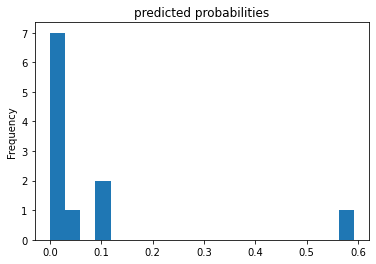

In [ ]:
pred_dicts = list(linear_est.predict(eval_input_fn))
probs = pd.Series([pred['probabilities'][1] for pred in pred_dicts])

probs.plot(kind='hist', bins=20, title='predicted probabilities')

In [150]:
result = list(linear_est.predict(eval_input_fn))
p = 0
redwincount = 0
bluewincount = 0
erros = 0
acertos = 0

for _ in range(103):
  time.sleep(1)
  winner_ = eval.iat[p,30]
  print(p)
  resultblue = float(result[p]['probabilities'][1])
  resultred = float(result[p]['probabilities'][0])
  print(resultblue * 100, "% de chance")
  print(resultred * 100, "% de chance")
  
  p = p + 1
  print("Acho que o vencedor foi o:", winner_)
 
  
  if resultred > 0.500000:
    redwincount = redwincount + 1
    print("Bluewincount:", bluewincount)
    print("Redwincount:", redwincount)
    if winner_ != 0:
      print("Eu errei, meeeeeeeee")
      erros = erros + 1
      print("Total de erros:", erros)
      print("Total de acertos:", acertos)
    else:
      print("Hmmm analizando o resultado real da partida, eu acertei hihi")
      acertos = acertos + 1
      print("Total de erros:", erros)
      print("Total de acertos:", acertos)

    
  else:
     bluewincount = bluewincount + 1
     print("Bluewincount:", bluewincount)
     print("Redwincount:", redwincount)
     if winner_ != 1:
      print("Eu errei, meeeeeeeeeeeeeee")
      erros = erros + 1
      print("Total de erros:", erros)
      print("Total de acertos:", acertos)
     else:
      print("Hmmm analizando o resultado real da partida, eu acertei hihi")
      acertos = acertos + 1
      print("Total de erros:", erros)
      print("Total de acertos:", acertos)
     
  
  







INFO:tensorflow:Calling model_fn.


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/base_layer_v1.py:1727: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpwh7phvjw/model.ckpt-1170
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
0
2.4146828800439835 % de chance
97.58532047271729 % de chance
Acho que o vencedor foi o: 0
Bluewincount: 0
Redwincount: 1
Hmmm analizando o resultado real da partida, eu acertei hihi
Total de erros: 0
Total de acertos: 1
1
0.269288569688797 % de chance
99.73070621490479 % de chance
Acho que o vencedor foi o: 0
Bluewincount: 0
Redwincount: 2
Hmmm analizando o resultado real da partida, eu acertei hihi
Total de erros: 0
Total de acertos: 2
2
7.8370556235313416 % de chance
92.16294884681702 % de chance
Acho que o vencedor foi o: 0
Bluewincount: 0
Redwincount: 3
Hmmm analizando o resultado real da partida, eu acertei hihi
Total de erros: 0
Total de acertos: 3
3
0.024682682123966515 % de chance
99.97531771659851 % de chance
Acho que o vencedor foi o: 0
Bluewin

KeyboardInterrupt: ignored

0
